# MBTA Analysis of Wait Times

Modelling wait times pre and post construction to determine causal relationships

In [8]:
 #--- IMPORTS--------------------------------------------------------------
import numpy as np
 # fast math + arrays
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
 # read CSVs, data tables
 # probability models + .fit()
 # plotting
from statsmodels.distributions.empirical_distribution import ECDF
 # ECDF: nonparametric cumulative curve
 #--- OPTIONAL PLOT STYLE (makes plots cleaner; OK to skip)----------------
plt.rcParams.update({
 "axes.spines.top": False,
 # cleaner axes
"axes.spines.right": False,
 "axes.grid": True,
 "grid.alpha": 0.25,
})

In [9]:
def plot_ecdf(data, ax=None, **kw):
    """
    Make an ECDF step plot.
    WHY: shows all data points; no bins; great for comparing to model CDFs.
    """
    ec = ECDF(data)
 # compute ECDF object (x,y steps)
    ax = ax or plt.gca()
 # use passed axes OR current axes
    ax.step(ec.x, ec.y, where="post", **kw)
    ax.set_xlabel("Wait (min)")
    ax.set_ylabel("F_hat(x)")
 # F-hat = empirical CDF
    return ax
def aic(logL, k):
 """
 Compute Akaike Information Criterion.
 AIC = 2*k- 2*logL
 logL = maximized log-likelihood; k = # free parameters in model.
 Lower AIC-> better tradeoff fit vs complexity (same dataset only!).
 """
 return 2*k- 2*logL
def mean_from_params(dist_name, params):
    """
    Convert SciPy .fit() parameters-> model mean (in minutes).
    SciPy returns (shape[s], loc, scale) in this order for most continuous dists.
    NOTE: ’loc’ shifts the distribution; ’scale’ stretches it.
    """
    if dist_name == "gamma":
        a, loc, scale = params
    # a = shape (k)
        return loc + a*scale
    elif dist_name == "weibull_min":
        c, loc, scale = params
    # Gamma mean = loc + k*theta
    # c = shape
    # Weibull mean uses the gamma function:
        return loc + scale*st.gamma(1 + 1/c)
    elif dist_name == "lognorm":
        s, loc, scale = params
    # s = sigma (log-scale SD); scale = exp(mu)
    # mean = loc + scale * exp( sigma^2 / 2 )
        return loc + scale * np.exp(s**2 / 2)
    else:
        return np.nan
    # unknown mode

In [13]:
import os
os.listdir()

['mbta-analysis.ipynb', 'mbta_wait_times.csv']

In [18]:
df = pd.read_csv("mbta_wait_times.csv")
pre = df.loc[df["period"] == "PRE","wait_min"].to_numpy()
post = df.loc[df["period"] == "POST","wait_min"].to_numpy()
print(f"PRE n={pre.size}, mean={pre.mean():.2f} min")
print(f"POST n={post.size}, mean={post.mean():.2f} min")

PRE n=600, mean=3.85 min
POST n=650, mean=4.84 min


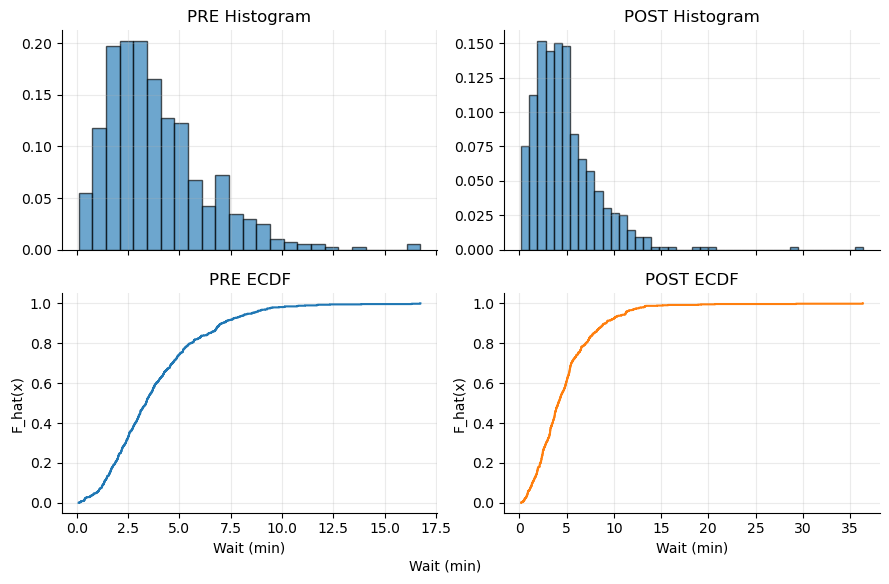

In [20]:
#--- 22 GRID: histograms (top) + ECDFs (bottom)-------------------------
fig, axs = plt.subplots(2, 2, figsize=(9,6), sharex='col')
 # TOP ROW: HISTOGRAMS show approximate density
axs[0,0].hist(pre, bins="auto", density=True, alpha=.65, edgecolor="k")
axs[0,0].set_title("PRE Histogram")
axs[0,1].hist(post, bins="auto", density=True, alpha=.65, edgecolor="k")
axs[0,1].set_title("POST Histogram")
# BOTTOM ROW: ECDFS show cumulative % of waits <= x
plot_ecdf(pre, ax=axs[1,0], color="C0"); axs[1,0].set_title("PRE ECDF")
plot_ecdf(post, ax=axs[1,1], color="C1"); axs[1,1].set_title("POST ECDF")
fig.text(0.5,0.04,"Wait (min)", ha="center")
fig.tight_layout(rect=[0,0.04,1,1])
plt.show()

We can see POST is more spread out, while PRE is more right skewed

In [30]:
iqr_pre = np.percentile(pre, 75) - np.percentile(pre, 25)
outliers_pre = []
for x in pre:
    if x<np.percentile(pre,25)-1.5*iqr_pre or x>np.percentile(pre,75)+iqr_pre*1.5:
        outliers_pre.append(x)
iqr_post = np.percentile(post, 75) - np.percentile(post,25)
outliers_post = []
for x in post:
    if x<np.percentile(pre,25)-1.5*iqr_pre or x>np.percentile(pre,75)+iqr_pre*1.5:
        outliers_post.append(x)
print(f"PRE outliers: {(outliers_pre)}")
print(f"POST outliers: {(outliers_post)}")

PRE outliers: [np.float64(10.140301361924095), np.float64(12.329866645380712), np.float64(10.103327683786627), np.float64(9.450312777673624), np.float64(9.53380559359136), np.float64(10.779048035513943), np.float64(10.729393331843577), np.float64(11.696088188412755), np.float64(16.747253791076403), np.float64(13.875048039255976), np.float64(9.853289622499425), np.float64(11.739244918496466), np.float64(11.120463173855216), np.float64(9.422282193191313), np.float64(16.31647512129235)]
POST outliers: [np.float64(11.525516593551666), np.float64(13.371061233084175), np.float64(9.843862522359036), np.float64(18.90672242169352), np.float64(13.287068768093212), np.float64(10.357978176266911), np.float64(19.247471907444726), np.float64(20.70682148802069), np.float64(11.17100942456317), np.float64(11.640024064735115), np.float64(11.293556827378728), np.float64(10.874199762982077), np.float64(11.211019734070362), np.float64(9.587804340920504), np.float64(11.33615895919411), np.float64(10.2392346

In [31]:
candidates = {
 "gamma": st.gamma,
 "weibull_min": st.weibull_min, # swap/add "lognorm": st.lognorm if you like
 "lognorm": st.lognorm,
 }
print("Candidate models:", list(candidates))

Candidate models: ['gamma', 'weibull_min', 'lognorm']



We picked Gamma and Lognorm because the data is positive and skewed right. We picked Beibull minimum because it is common in reliablity and waiting.


In response to the question about the friend who suggested using normal distribution, we don't want that because 

1) The train data has fully positive wait times, and therefore normal distribution wouldn't work
2) Sampling the data many times would not lead it converging to a normal; it would actually converge to the population distribution. In fact, it is the means of the samples of datas that converge to a normal distribution around the population mean as you sample many times

In [32]:
def fit_models(data, models):
    """
    Fit each SciPy distribution in ‘models‘ to 1-D numpy array ‘data‘.
    Returns a DataFrame (rows = models, columns = params/logL/k/AIC) sorted by AIC.
    """
    out = {}
    for name, dist in models.items():
        params = dist.fit(data)
        # MLE: find params that max log-likelihood
        logL = dist.logpdf(data, *params).sum() # total log-likelihood at those params
        k = len(params)
        # number of fitted parameters
        out[name] = dict(params=params, logL=logL, k=k, AIC=aic(logL,k))
    return pd.DataFrame(out).T.sort_values("AIC") # lower AIC = better
    #--- FIT PRE & POST-------------------------------------------------------
fit_pre = fit_models(pre, candidates)
fit_post = fit_models(post, candidates)
print("PRE fits:"); display(fit_pre)
print("POST fits:"); display(fit_post)

PRE fits:


,params,logL,k,AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927
lognorm,"(0.4535837982450181, -1.2934360536889793, 4.64...",-1298.316753,3,2602.633505
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf


POST fits:


,params,logL,k,AIC
lognorm,"(0.5360203743986024, -1.0685227608888774, 5.12...",-1578.630755,3,3163.261511
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013


The row in the fit_pre table with the lowest AIC is the gamma distribution
The row in the fit_post table with the lowest AIC is the lognorm distribution

PRE Best Model = Gamma (AIC = 2600.902)

POST Best Model = Lognorm (AIC = 31)

In [33]:
fit_pre["delta_AIC"] = fit_pre["AIC"] - fit_pre["AIC"].min()
fit_post["delta_AIC"] = fit_post["AIC"] - fit_post["AIC"].min()

In [34]:
fit_pre

,params,logL,k,AIC,delta_AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927,0.0
lognorm,"(0.4535837982450181, -1.2934360536889793, 4.64...",-1298.316753,3,2602.633505,1.730578
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf,inf


In [35]:
fit_post

,params,logL,k,AIC,delta_AIC
lognorm,"(0.5360203743986024, -1.0685227608888774, 5.12...",-1578.630755,3,3163.261511,0.0
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653,0.391489
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013,150.507502


PRE_period: 

Delta_AIC<=2: {gamma,lognorm}

4<=Delta_AIC<=7: {None}

Delta_AIC>=10: {Weibull_Min}

POST_period: 

Delta_AIC<=2: {lognorm,gamma}

4<=Delta_AIC<=7: {None}

Delta_AIC>=10: {Weibull_Min}

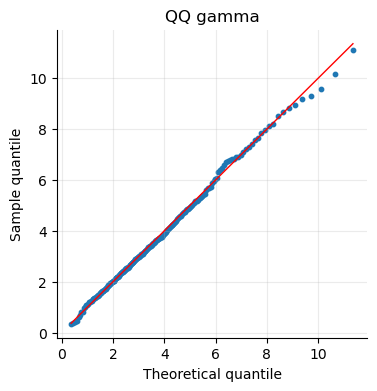

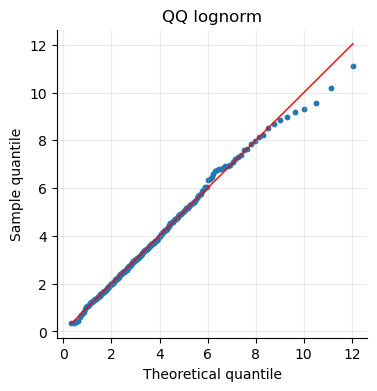

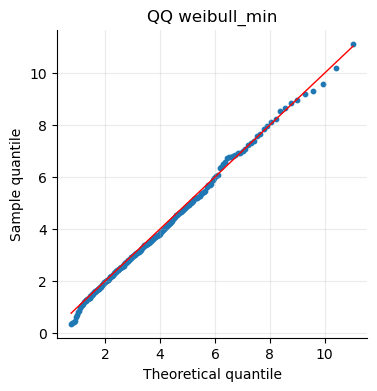

In [37]:
def qq_compare(data, fit_tbl, models, probs=np.linspace(.01,.99,200)):
    """
    Make QQ plots for each fitted model in fit_tbl.
    ‘probs‘ are the quantile levels (0-1) we compare.
    """
    qs = np.quantile(data, probs)
    # sample quantiles from data
    for name in fit_tbl.index:
        dist = models[name]
        params = fit_tbl.loc[name,"params"]
        qt = dist.ppf(probs, *params)
        plt.figure(figsize=(4,4))
        plt.scatter(qt, qs, s=10)
        plt.plot(qt, qt, 'r', lw=1)
        plt.title(f"QQ {name}")
        plt.xlabel("Theoretical quantile")
        plt.ylabel("Sample quantile")
        plt.show()
qq_compare(pre,fit_pre,candidates)

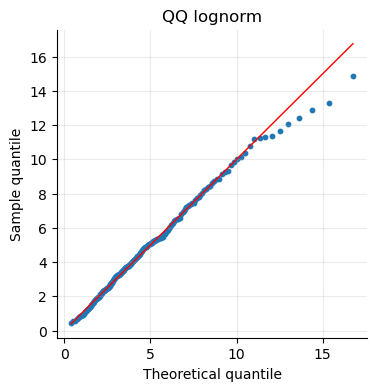

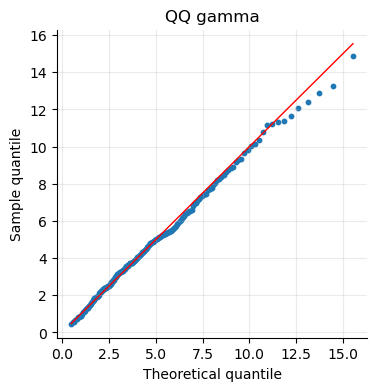

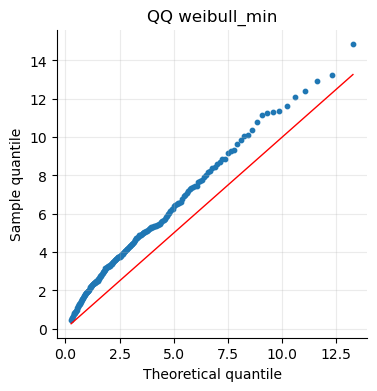

In [38]:
qq_compare(post,fit_post,candidates)

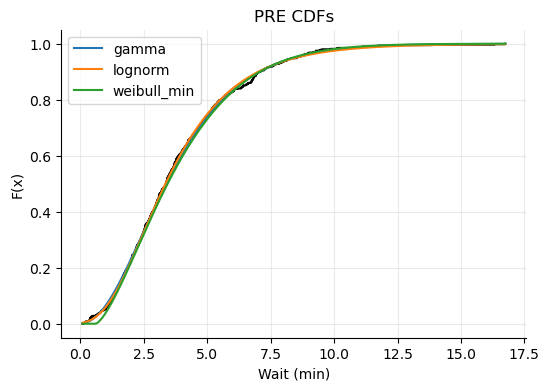

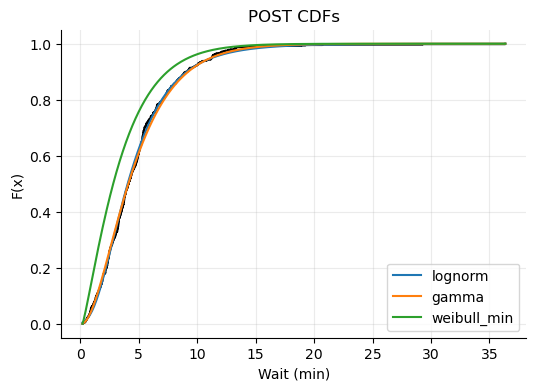

In [42]:
def cdf_overlay(data, fit_tbl, models, title):
    """
    ECDF (black steps) + each fitted model’s CDF (smooth lines).
    """
    plt.figure(figsize=(6,4))
    plot_ecdf(data, color="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.cdf(xx, *pars), label=name)
        plt.legend()
        plt.title(title)
        plt.xlabel("Wait (min)"); plt.ylabel("F(x)")
cdf_overlay(pre,fit_pre,candidates,"PRE CDFs")
cdf_overlay(post,fit_post,candidates,"POST CDFs")

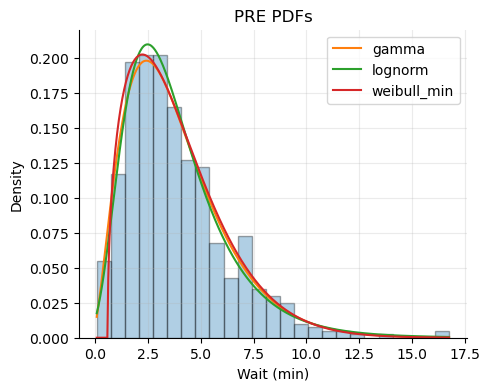

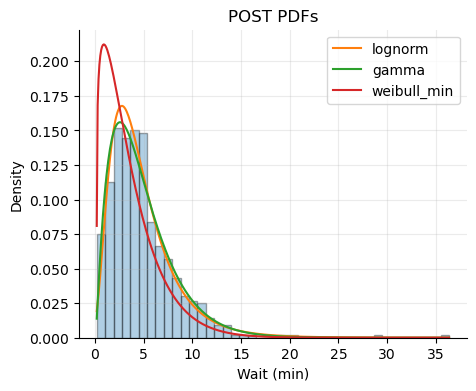

In [44]:
def pdf_overlay(data, fit_tbl, models, title):
    """
    Histogram (density=True) + PDFs from each fitted model.
    """
    plt.figure(figsize=(5,4))
    plt.hist(data, bins="auto", density=True, alpha=.35, edgecolor="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.pdf(xx, *pars), label=name)
        plt.legend(); plt.title(title)
        plt.xlabel("Wait (min)"); plt.ylabel("Density")

pdf_overlay(pre,fit_pre,candidates,title="PRE PDFs")
pdf_overlay(post,fit_post,candidates,title="POST PDFs")

In which period (PRE vs POST) do models struggle most in the upper tail?

In the PRE period models struggle in the upper tail


 Q5.2. Do outliers visibly stretch or pull any model curves


 Yes, they pull the curves outward

In [47]:
#--- PICK BEST MODELS BY AIC----------------------
best_pre = fit_pre.index[0]
best_post = fit_post.index[0]
 #--- GET MEANS FROM FITTED PARAMS-----------------------------------------
mu_pre = mean_from_params(best_pre, fit_pre.loc[best_pre,"params"])
mu_post = mean_from_params(best_post, fit_post.loc[best_post,"params"])
 #--- PRACTICAL CHANGE------------------------------------------------------
delta = mu_post- mu_pre
ratio = mu_post / mu_pre
print(f"Best PRE model: {best_pre} | mean: {mu_pre:.2f} min")
print(f"Best POST model: {best_post} | mean: {mu_post:.2f} min")
print(f"Change POST-PRE: {delta:+.2f} min ({ratio:.2f})")

Best PRE model: gamma | mean: 3.85 min
Best POST model: lognorm | mean: 4.84 min
Change POST-PRE: +0.99 min (1.26)


After construction, typical waits are about 1 minute longer.


Decide: Is that difference practically important (e.g., enough to leave 1–2 minutes earlier)?

Yes, I would say so as people may need to leave 1-2 minutes earlier.

If two models had ∆AIC< 2, does this imply that the result of a slow down is more or less
 robust? Why?

If two models had AIC_delta<2, and they both implied slowdowns with their means, that would signify that the result of a slow down is more robust as two different yet accurate distributions support it.